<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/CNN_on_MNIST_by_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
from torch.utils import data
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [1]:
!pip install wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 144 kB 38.1 MB/s 
     |████████████████████████████████| 181 kB 44.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4991cb6c2c53c155bd9363df1b406904b0c49c016c91ac2e383aceaa7e7462f8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt

In [30]:
mnist_tr = dset.MNIST("./dataset/mnist", train=True, download=True, transform=T.ToTensor())
mnist_te = dset.MNIST("./dataset/mnist", train=False, download=True, transform=T.ToTensor())

NUM_TRAIN = 50000
NUM_VALID = 10000
NUM_TEST = 10000

batch_size = 128

loader_tr = DataLoader(mnist_tr, batch_size=batch_size, shuffle=True)
loader_va = DataLoader(mnist_tr, batch_size=batch_size, shuffle=True)
loader_te = DataLoader(mnist_te, batch_size=batch_size, shuffle=True)

'\nloader_tr = DataLoader(mnist_tr, batch_size=batch_size, sampler=sampler.Sampler(NUM_TRAIN))\nloader_va = DataLoader(mnist_tr, batch_size=batch_size, sampler=sampler.Sampler(NUM_VALID))\nloader_te = DataLoader(mnist_te, batch_size=batch_size, sampler=sampler.Sampler(NUM_TEST))\n'

In [63]:
def build_classifier():
  return nn.Sequential(
    nn.Conv2d(in_channels=1,
              out_channels=16,
              kernel_size=3,
              stride=2,
              padding=1,
              padding_mode='zeros',
              bias=True),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=1),
    nn.Conv2d(in_channels=16,
              out_channels=32,
              kernel_size=3,
              stride=2,
              padding=0,
              bias=True),
    nn.LeakyReLU(0.01),
    nn.MaxPool2d(kernel_size=2,
                 stride=1,
                 padding=0),
    nn.Conv2d(in_channels=32,
              out_channels=64,
              kernel_size=3,
              stride=2,
              padding=0,
              bias=True),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(64*2*2, 100),
    nn.LeakyReLU(0.01),
    nn.Linear(100, 10),
    nn.Softmax(dim=1)
).cuda(0)

In [96]:
dtype = torch.cuda.FloatTensor
model = build_classifier()
cost_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
cost_list = []
for epoch in range(5):
  for x, y in loader_tr:
    if len(x) != batch_size:
      continue
    y_hat = model(x.type(dtype)).cpu()
    cost = cost_func(y_hat, y)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    cost_list.append(cost.detach().numpy())

  incorrect = 0
  for x, y in loader_va:
    y_hat = model(x.type(dtype)).cpu().detach().numpy().argmax(axis=1)
    for i in range(len(y)):
      if y[i] != y_hat[i]:
        incorrect += 1
  print('epoch:{}, acurracy:{:.3f}, error rate:{:.3f}'.format(epoch+1, 1-incorrect/60000, incorrect/60000))

epoch:1, acurracy:0.929, error rate:0.071
epoch:2, acurracy:0.957, error rate:0.043
epoch:3, acurracy:0.972, error rate:0.028
epoch:4, acurracy:0.978, error rate:0.022
epoch:5, acurracy:0.982, error rate:0.018


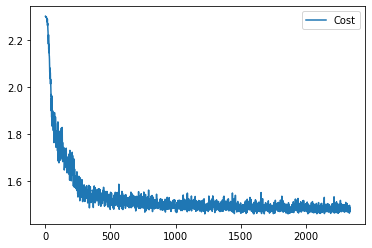

In [98]:
plt.figure('PyTorch_CNN_Cost')
plt.plot(cost_list,label='Cost')
plt.legend()

In [97]:
incorrect = 0
for x, y in loader_te:
  y_hat = model(x.type(dtype)).cpu().detach().numpy().argmax(axis=1)
  for i in range(len(y)):
    if y[i] != y_hat[i]:
      incorrect += 1
print('Test: acurracy:{:.3f}, error rate:{:.3f}'.format(1-incorrect/10000, incorrect/10000))

Test: acurracy:0.981, error rate:0.019
